In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist

In [ ]:
def train_digit_recognition_model():
    # Load the MNIST dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Normalize the data to values between 0 and 1
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    # Create a simple neural network model
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model on the training data
    model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {test_accuracy}")

    # Save the model for later use
    model.save('digit_recognition_model.h5')

Enter the path to the image: "C:\Users\bugra\Desktop\python_images\example1.jpg"


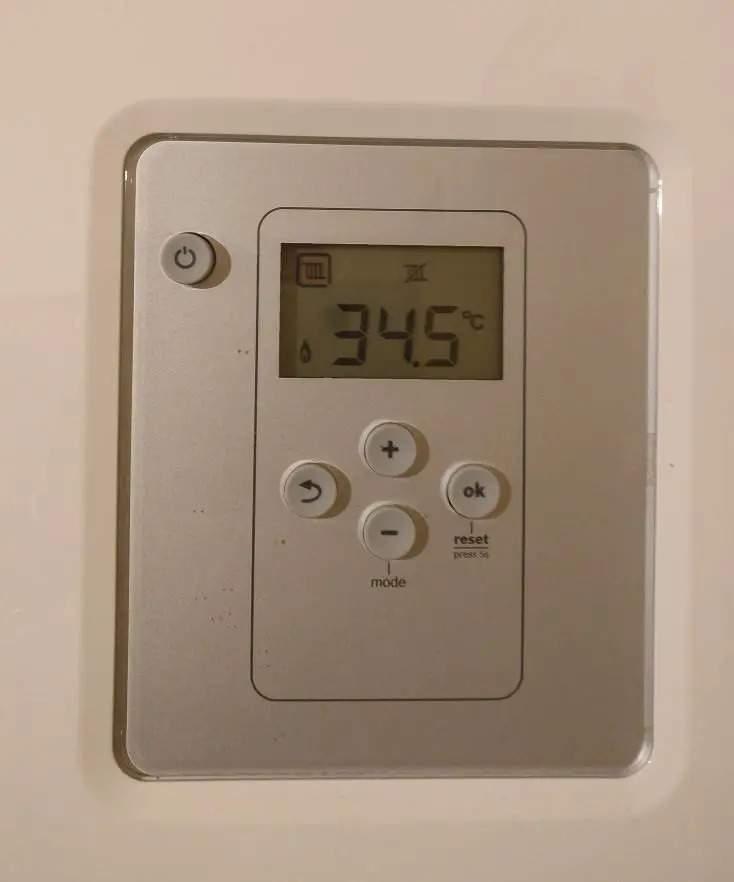

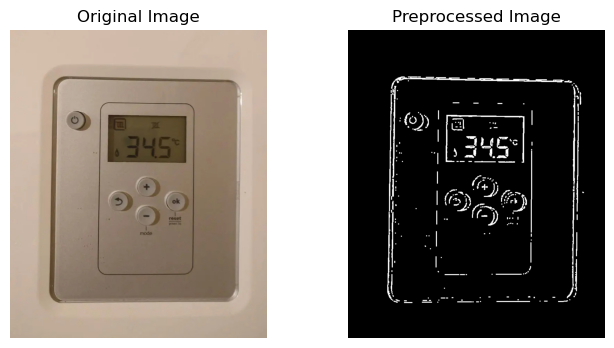

1/1 [==============================] - 0s 15ms/step


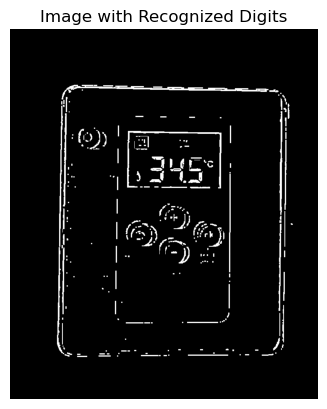

Enter the number to match (0-9): 3
The number 3 is present in the image at indices: [0, 2, 4, 10, 14, 20]


In [10]:


def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Use adaptive thresholding to better segment the digits
    thresholded = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # Apply morphological operations for noise reduction and enhancing digit representation
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(thresholded, kernel, iterations=1)
    dilated = cv2.dilate(eroded, kernel, iterations=1)

    return dilated

def find_digits(image):
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    digit_contours = []
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if w >= 5 and h >= 25 and w < 100 and h < 100:  # Filter based on width and height
            digit_contours.append(contour)
    return digit_contours

def recognize_digits(image, model):
    recognized_digits = []
    digit_contours = find_digits(image)

    for digit in digit_contours:
        (x, y, w, h) = cv2.boundingRect(digit)
        roi = image[y:y + h, x:x + w]

        # Resize the ROI to 28x28 to match the model's input size
        roi_resized = cv2.resize(roi, (28, 28))

        # Normalize and flatten the ROI for prediction
        roi_normalized = roi_resized.astype('float32') / 255.0
        roi_flattened = roi_normalized.reshape(1, 28, 28, 1)

        # Use the pre-trained model to predict the digit
        result = model.predict(roi_flattened)
        digit_prediction = np.argmax(result)

        # Draw rectangles around recognized digits on the preprocessed image
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Store the recognized digit
        recognized_digits.append(digit_prediction)

    return recognized_digits, image

if __name__ == "__main__":
    # Check if the model is already trained, if not, load a pre-trained model
    try:
        model = tf.keras.models.load_model('digit_recognition_model.h5')
    except OSError:
        print("Error: The digit recognition model is not found. Please train the model first.")
        exit()

    # Take input from the user: image path and the number to match
    image_path = input("Enter the path to the image: ").strip('"\'')

    # Display the uploaded image
    img = Image.open(image_path)
    display(img)

    # Read the input image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to read the image.")
        exit()

    # Preprocess the image and find digit contours
    preprocessed_image = preprocess_image(image)

    # Display the original and preprocessed images side by side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed_image, cmap='gray')
    plt.title("Preprocessed Image")
    plt.axis('off')

    plt.show()

    # Recognize digits using the model and display the extracted digits on the preprocessed image
    recognized_digits, image_with_digits = recognize_digits(preprocessed_image, model)

    # Display the image with recognized digits
    plt.imshow(cv2.cvtColor(image_with_digits, cv2.COLOR_BGR2RGB))
    plt.title("Image with Recognized Digits")
    plt.axis('off')
    plt.show()

    # Take input from the user: number to match
    number_to_match = int(input("Enter the number to match (0-9): "))

    # Compare recognized digits with the number to match
    matching_indices = [i for i, digit in enumerate(recognized_digits) if digit == number_to_match]

    if matching_indices:
        print(f"The number {number_to_match} is present in the image at indices:", matching_indices)
    else:
        print(f"The number {number_to_match} is not found in the image.")

"C:\Users\bugra\Desktop\python_images\example1.jpg"